## save to drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mv /content/pruned_transformer30pct.pth /content/pruned_transformer30pct_all_layers.pth

In [ ]:
!cp /content/pruned_transformer30pct_all_layers.pth /content/gdrive/MyDrive/Research/Data/

## imports

In [ ]:
!pip install transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForQuestionAnswering
from datasets import load_dataset
from evaluate import load
from transformers.data.metrics import squad_metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from copy import deepcopy
import math
import random
from transformers.pytorch_utils import find_pruneable_heads_and_indices
import time

## pruning algorithm steps

### step 1: compute gradient

In [ ]:
def compute_grads(layer, H, U, attn_mask, head_mask, device='cpu'):
  # layer = layer.to(device)
  # attn_mask = attn_mask.to(device)

  # query, key, value = H.to(device), H.to(device), H.to(device)
  query, key, value = H, H, H
  attn = layer(H, H, H, attn_mask, head_mask=head_mask, output_attentions=False)[-1]
  attn.retain_grad()

  loss = residual_objective(attn - U)
  loss.backward()

  dA = attn.grad # attn.grad should be = attn - U
  # maybe instead of using attn grad, should aggregate parameter grads? either for weights only or for all

  with torch.no_grad():
    grad_dict = {}
    for name, parameter in layer.named_parameters():
      grad_dict[name] = parameter.grad

    layer.zero_grad()
    attn.grad = None

    dA_sep = separate_heads(dA, dA.shape[0], layer.n_heads, layer.dim // layer.n_heads)

  return dA_sep, grad_dict, loss.item()

### step 2: find best s columns of grad outside S and merge with S

In [ ]:
@torch.no_grad()
def find_and_merge(dA, S, n_heads_to_keep, device='cpu'):
  dA = dA.to(device)
  importance = torch.norm(dA, p=2, dim=(0, 2, 3))
  del dA
  for index in S:
    importance[index] = 0
  imp_top_idxs = torch.argsort(importance, descending=True)[:n_heads_to_keep]
  imp_top_idxs = set(imp_top_idxs.tolist())
  # print(f'top idxs of grad: {imp_top_idxs}, S: {S}')
  D = S.union(imp_top_idxs)

  return D

### step 3: update parameters by gradient descent focused on D

In [ ]:
@torch.no_grad()
def update_step(Q, grad_dict, qkv_optimizer, out_optimizer, D, device=None):
  for name, Q_param in Q.named_parameters():
    if name in grad_dict:
      Q_param.grad = grad_dict[name]
    else:
      print(f'No gradient for {name}')

  indexer = get_mask_indexer(D, Q.n_heads, Q.attention_head_size)
  qkv_optimizer.step(indexer)
  out_optimizer.step(indexer)
  return Q

### step 4: truncate Q to be s-sparse

In [ ]:
@torch.no_grad()
def truncate(Q, H, U, attn_mask, head_mask, n_heads_to_keep, device='cpu'):
  attn = Q(H, H, H, attn_mask, head_mask=head_mask, output_attentions=False)[-1] # can also compute some norm over the different params
  attn_sep = separate_heads(attn, attn.shape[0], Q.n_heads, Q.dim // Q.n_heads)
  attn_imp = torch.norm(attn_sep, p=2, dim=(0, 2, 3))
  imp_top_idxs = torch.argsort(attn_imp, descending=True)[:n_heads_to_keep]
  S = set(imp_top_idxs.cpu().tolist())

  layer = deepcopy(Q)
  layer = zero_out(S, layer)

  # q = Q.q_lin.weight.data
  # q_sep = q.view(12, 64, 768)
  # print(torch.norm(q_sep, p=2, dim=(1, 2)))
  # qb = Q.q_lin.bias.data
  # qb_sep = qb.view(12, 64)
  # print(torch.norm(qb_sep, p=2, dim=(1)))


  return layer, S

### step 5: debias

In [ ]:
def debias(pruned_layer, Q, S, H, U, qkv_optimizer, out_optimizer, iters, attn_mask, head_mask, eta=None, device='cpu'):
  # optimizer = optim.SGD(pruned_layer.parameters())
  for i in range(iters):
    pruned_layer.zero_grad()

    attn = pruned_layer(H, H, H, attn_mask, head_mask=head_mask, output_attentions=False)[-1]
    loss = residual_objective(attn - U)
    loss.backward()

    with torch.no_grad():
      not_S_indexer = get_mask_indexer(S, pruned_layer.n_heads, pruned_layer.attention_head_size)
      for (Q_name, Q_param), (W_name, W_param) in zip(Q.named_parameters(), pruned_layer.named_parameters()):
        assert Q_name == W_name, f"param name mismatch. Q param = {Q_name}, W param = {W_name}"
        Q_param.grad = W_param.grad

      qkv_optimizer.step()
      out_optimizer.step()

      S_indexer = get_mask_indexer(set(range(pruned_layer.n_heads)).difference(S), pruned_layer.n_heads, pruned_layer.attention_head_size)

      for (name, Q_param), (W_param) in zip(Q.named_parameters(), pruned_layer.parameters()):
        if 'bias' in name:
          if 'out' in name:
            pass
          else:
            W_param.data[S_indexer] = Q_param.data[S_indexer]
        else:
          if 'out' in name:
            W_param.data[:, S_indexer] = Q_param.data[:, S_indexer]
          else:
            W_param.data[S_indexer, :] = Q_param.data[S_indexer, :]

  return pruned_layer, Q

## pruning algorithm utils

In [ ]:
def validate(args, model, ids, inputs, answers, metric, device='cpu'):
  model = model.to(device)
  inputs = inputs.to(device)
  with torch.no_grad():
    start_sp = time.time()
    outputs_sp = model(**inputs)
    end_sp = time.time()
    if args.verbose:
      print(f'done predicting using sparse model. time elapsed = {end_sp - start_sp}s')

  model = model.cpu()
  inputs = inputs.to('cpu')

  num_examples = len(ids)
  preds = []
  refs = []
  for i in range(num_examples):
    answer_start_index_sp = torch.argmax(outputs_sp.start_logits[i])
    answer_end_index_sp = torch.argmax(outputs_sp.end_logits[i])
    predict_answer_tokens_sp = inputs.input_ids[i, answer_start_index_sp : answer_end_index_sp + 1]
    pred_sp = tokenizer.decode(predict_answer_tokens_sp)

    pred = {'id': ids[i], 'prediction_text': pred_sp}
    preds.append(pred)
    ref = {'answers': answers[i], 'id': ids[i]}
    refs.append(ref)

  results = metric.compute(predictions=preds, references=refs)

  #   possible_answers = answers[i]['text']
  #   for j in range(len(possible_answers)):
  #     possible_answers[j] = possible_answers[j].lower()

  #   correct_sp = int(answer_sp in possible_answers)

  #   if args.verbose:
  #     print('\nTEXT:', texts[i])
  #     print('QUESTION:', questions[i])
  #     print('MODEL ANSWER:', answer_sp)
  #     print('EXPECTED ANSWER:', possible_answers)
  #     print('CORRECT' if correct_sp else 'WRONG')

  #   total_correct_sp += correct_sp

  # avg_correct_sp = total_correct_sp / num_examples

  # if args.verbose:
  #   print('validation accuracy:', avg_correct_sp*100)

  return results

In [ ]:
class SparseAdam(torch.optim.Optimizer):
  def __init__(self, params, lr=5e-5, betas=(0.9, 0.999), eps=1e-8, correct_bias=False, sparsity='row'):
    if lr < 0.0:
        raise ValueError(f"Invalid learning rate: {lr} - should be >= 0.0")
    if not 0.0 <= betas[0] < 1.0:
        raise ValueError(f"Invalid beta parameter: {betas[0]} - should be in [0.0, 1.0)")
    if not 0.0 <= betas[1] < 1.0:
        raise ValueError(f"Invalid beta parameter: {betas[1]} - should be in [0.0, 1.0)")
    if not 0.0 <= eps:
        raise ValueError(f"Invalid epsilon value: {eps} - should be >= 0.0")
    if sparsity != 'col' and sparsity != 'row':
        raise ValueError(f"Invalid sparsity value: {sparsity} - must be 'row' or 'col'")

    defaults = dict(lr=lr, betas=betas, eps=eps, correct_bias=correct_bias, sparsity=sparsity)
    super(SparseAdam, self).__init__(params, defaults)

  def step(self, indexer):
    for group in self.param_groups:
      for p in group["params"]:
        if p.grad is None:
          continue
        grad = p.grad

        sparsity = group["sparsity"]
        if sparsity == 'row':
          grad[indexer] = 0 # zero out grad
        elif sparsity == 'col':
          grad[:, indexer] = 0

        state = self.state[p]

        # State initialization
        if len(state) == 0:
          state["step"] = 0
          # Exponential moving average of gradient values
          state["m"] = torch.zeros_like(p)
          # Exponential moving average of squared gradient values
          state["v"] = torch.zeros_like(p)

        m_tm1, v_tm1 = state["m"], state["v"]
        beta1, beta2 = group["betas"]

        state["step"] += 1

        m_t = beta1 * m_tm1 + (1 - beta1) * grad
        if sparsity == 'row':
          m_t[indexer] = 0 # zero out m_t
        elif sparsity == 'col':
          m_t[:, indexer] = 0

        v_t = beta2 * v_tm1 + (1 - beta2) * torch.pow(grad, 2)
        if sparsity == 'row':
          v_t[indexer] = 0 # zero out v_t
        elif sparsity == 'col':
          v_t[:, indexer] = 0

        step_size = group["lr"]
        if group["correct_bias"]:  # No bias correction for Bert
          bias_correction1 = 1.0 - beta1 ** state["step"]
          bias_correction2 = 1.0 - beta2 ** state["step"]
          step_size = step_size * math.sqrt(bias_correction2) / bias_correction1

        p.data = p.data - step_size * m_t / (torch.sqrt(v_t) + group["eps"])

        state["m"] = m_t
        state["v"] = v_t

In [ ]:
class InputDataset(Dataset):
  def __init__(self, attn_masks, hidden_states):
    self.attn_masks = attn_masks
    self.hidden_states = hidden_states

  def __len__(self):
    return self.hidden_states.shape[0]

  def __getitem__(self, idx):
    return self.attn_masks[idx], self.hidden_states[idx]

In [ ]:
@torch.no_grad()
def zero_out(S, layer):
  heads_to_keep = S
  heads_to_prune = set(range(layer.n_heads)).difference(heads_to_keep)
  indexer_to_prune = get_mask_indexer(heads_to_keep, layer.n_heads, layer.attention_head_size)

  for name, parameter in layer.named_parameters():
    if 'bias' in name:
      if 'out' in name:
        pass
      else:
        parameter.data[indexer_to_prune] = 0
    else:
      if 'out' in name:
        parameter.data[:, indexer_to_prune] = 0
      else:
        parameter.data[indexer_to_prune, :] = 0

  return layer

In [ ]:
def get_transformer_arguments(
    model,
    input_ids = None,
    attention_mask = None,
    head_mask = None,
    inputs_embeds = None,
    output_attentions = None,
    output_hidden_states = None,
    return_dict = None):

  output_attentions = output_attentions if output_attentions is not None else model.config.output_attentions
  output_hidden_states = (
      output_hidden_states if output_hidden_states is not None else model.config.output_hidden_states
  )
  return_dict = return_dict if return_dict is not None else model.config.use_return_dict

  if input_ids is not None and inputs_embeds is not None:
      raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
  elif input_ids is not None:
      input_shape = input_ids.size()
  elif inputs_embeds is not None:
      input_shape = inputs_embeds.size()[:-1]
  else:
      raise ValueError("You have to specify either input_ids or inputs_embeds")

  device = input_ids.device if input_ids is not None else inputs_embeds.device

  if attention_mask is None:
      attention_mask = torch.ones(input_shape, device=device)  # (bs, seq_length)

  # Prepare head mask if needed
  head_mask = model.get_head_mask(head_mask, model.config.num_hidden_layers)

  arguments = ({
                'output_attentions': output_attentions,
                'output_hidden_states': output_hidden_states,
                'return_dict': return_dict,
                'head_mask': head_mask,
                'attn_mask': attention_mask,
              })

  return arguments

In [ ]:
def get_data(d_name):
  dataset = load_dataset(d_name)
  train_dataset = dataset['train']
  test_ds = dataset['validation']

  split_ds = train_dataset.train_test_split(test_size=0.1)
  train_ds = split_ds['train']
  val_ds = split_ds['test']
  return train_ds, val_ds, test_ds

In [ ]:
@torch.no_grad()
def get_mask_indexer(heads_to_keep, n_heads, head_size):
  mask = torch.ones(n_heads, head_size)
  for head in heads_to_keep:
      mask[head] = 0
  mask = mask.view(-1).contiguous().eq(1)
  index = torch.arange(len(mask))[mask].long()
  return index

In [ ]:
# separate heads
def separate_heads(x, bs, n_heads, dim_per_head):
  return x.view(bs, -1, n_heads, dim_per_head).transpose(1, 2)

In [ ]:
class dotdict:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            if isinstance(value, dict):
                setattr(self, key, dotdict(value))
            else:
                setattr(self, key, value)

In [ ]:
def residual_objective(mat):
    return 0.5 * torch.mean(mat**2) # using torch.sum requires small stepsize (order of 1e-5)

## prune model

In [ ]:
def prune_distilbert(args, model=None, tokenizer=None, train_ds=None, val_ds=None, test_ds=None, device='cpu'):
  if train_ds is None and test_ds is None and val_ds is None:
    train_ds, val_ds, test_ds = get_data('squad')
  if tokenizer is None:
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-distilled-squad')
  if model is None:
    model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad')

  questions = train_ds['question']
  texts = train_ds['context']

  inputs = tokenizer(
        questions,
        texts,
        max_length=512,
        truncation="only_second",
        stride=128,
        padding="max_length",
        return_tensors='pt'
  )

  embedder = model.distilbert.embeddings
  transformer = model.distilbert.transformer

  transformer_arguments = get_transformer_arguments(model, **inputs)

  with torch.no_grad():
    embeddings = embedder(inputs.input_ids)

  val_arguments = {}
  if args.validate_iter or args.validate_layer:
    assert val_ds is not None
    start_idx = torch.randint(low=0, high=len(questions) - args.val_size, size=(1,)).item()

    val_ids = val_ds['id'][start_idx : start_idx + args.val_size]
    val_questions =  val_ds['question'][start_idx : start_idx + args.val_size]
    val_texts =  val_ds['context'][start_idx : start_idx + args.val_size]
    val_answers =  val_ds['answers'][start_idx : start_idx + args.val_size]

    val_inputs = tokenizer(
          val_questions,
          val_texts,
          max_length=512,
          truncation="only_second",
          stride=128,
          padding="max_length",
          return_tensors='pt'
    )

    val_arguments['ids'] = val_ids
    val_arguments['inputs'] = val_inputs
    val_arguments['answers'] = val_answers
    val_arguments['model'] = deepcopy(model)
    val_arguments['metric'] = load(args.dataset)

  pruned_transformer, val_mets = prune_transformer(args, transformer, embeddings, val_arguments, **transformer_arguments, device=device)

  if args.save_model:
    torch.save(pruned_transformer.state_dict(), '/content/pruned_transformer30pct.pth')
  return val_mets

## prune transformer

In [ ]:
def prune_transformer(args, transformer, hidden_states, val_arguments, validate_iter=False, attn_mask=None, output_attentions=None, head_mask=None, output_hidden_states=None, return_dict=None, device='cpu'):
  pruned_transformer = deepcopy(transformer)
  layers = pruned_transformer.layer

  all_val_mets = {}
  if args.validate_layer or args.validate_iter:
    val_arguments['model'].distilbert.transformer = pruned_transformer
    mets = validate(args, **val_arguments, device=device)
    all_val_mets['pre-pruning'] = mets
    print(f'Pre-pruning validation metrics = {mets}')

  for i, layer in enumerate(layers[:]):
    if i < args.min_layer or i > args.max_layer:
      continue
    input_ds = InputDataset(attn_mask, hidden_states)
    input_loader = DataLoader(input_ds, num_workers=2, shuffle=True, batch_size=args.batch_size)

    print(f'\nLayer {i}')

    layer.attention = prune_attn_layer(args, layer.attention, input_loader, head_mask[i], val_arguments, layer_id=i, device=device)

    if args.finetune_layer:
      if args.validate_layer:
        val_arguments['model'].distilbert.transformer = pruned_transformer
        mets = validate(args, **val_arguments, device=device)
        all_val_mets[f'layer {i}'] = mets
        print(f'Validation metrics after pruning layer {i}, before fine-tuning = {mets}')

      layer.attn = run_finetuning()

    layer = layer.to(device)
    hidden_states = hidden_states.to(device)
    attn_mask = attn_mask.to(device)

    with torch.no_grad():
      hidden_states = layer(
          x=hidden_states,
          attn_mask=attn_mask,
          output_attentions=output_attentions,
          head_mask=head_mask[i]
      )[-1]

    layer = layer.cpu()
    hidden_states = hidden_states.cpu()
    attn_mask = attn_mask.cpu()

    del input_ds
    del input_loader

    if args.validate_layer:
      val_arguments['model'].distilbert.transformer = pruned_transformer
      mets = validate(args, **val_arguments, device=device)
      all_val_mets[f'layer {i}'] = mets
      print(f'Validation metrics after pruning layer {i}, after fine-tuning = {mets}')

    if args.validate_iter:
      val_arguments['model'].distilbert.transformer = pruned_transformer

    # print(f'after pruning : shape of W_q = {layer.attention.q_lin}, n_heads = {layer.attention.n_heads}, shape of hidden_states = {hidden_states.shape}')

  if args.verbose:
    print(pruned_transformer)
  return pruned_transformer, all_val_mets

## prune layer

In [ ]:
def prune_attn_layer(args, layer, input_loader, head_mask, val_arguments, layer_id=None, device='cpu'):
  pruned_layer = deepcopy(layer)
  Q = deepcopy(pruned_layer)

  n_heads_to_keep = int(pruned_layer.n_heads * args.s)
  random_heads = random.sample(range(pruned_layer.n_heads), n_heads_to_keep)
  S = set(random_heads) # heads to keep

  pruned_layer = zero_out(S, pruned_layer) # zero out the heads of pruned_layer not in S

  pruned_layer = pruned_layer.to(device)
  Q = Q.to(device)

  qkv_params = []
  out_params = []
  for name, param in Q.named_parameters():
    if 'out' in name:
      if 'weight' in name:
        out_params.append(param)
      else:
        continue
    else:
      qkv_params.append(param)

  qkv_optimizer = SparseAdam(qkv_params, sparsity='row')
  out_optimizer = SparseAdam(out_params, sparsity='col')

  for t in range(args.T):
    if args.validate_iter:
      val_arguments['model'].distilbert.transformer.layer[layer_id].attention = pruned_layer
      acc = validate(args, **val_arguments, device=device)
      pruned_layer = pruned_layer.to(device)

    attn_mask, hidden_states = next(iter(input_loader))
    with torch.no_grad():
      attn_mask = attn_mask.to(device)
      hidden_states = hidden_states.to(device)
      query, key, value = hidden_states, hidden_states, hidden_states
      layer = layer.to(device)

      expected_outputs = layer(
          query=query,
          key=key,
          value=value,
          mask=attn_mask,
          output_attentions=False,
          head_mask=head_mask
      )[-1]
      layer = layer.cpu()

    dA, grad_dict, loss = compute_grads(pruned_layer, hidden_states, expected_outputs, attn_mask, head_mask, device=device)

    if args.validate_iter:
      print(f'Iteration {t}: S = {S} | Loss = {loss} | Exact Match = {acc["exact_match"]} | F1 = {acc["f1"]}')
    elif args.iter_verbose:
      print(f'Iteration {t}: S = {S} | Loss = {loss}')

    D = find_and_merge(dA, S, n_heads_to_keep, device=device)
    Q = update_step(Q, grad_dict, qkv_optimizer, out_optimizer, D, device=device)
    pruned_layer, S = truncate(Q, hidden_states, expected_outputs, attn_mask, head_mask, n_heads_to_keep, device=device)
    pruned_layer, Q = debias(pruned_layer, Q, S, hidden_states, expected_outputs, qkv_optimizer, out_optimizer, args.debias_iters, attn_mask, head_mask, eta=None, device=device)

    del grad_dict
    del dA

  del Q
  del layer

  print(f'Post-pruning: S = {S}')
  all_heads = set(range(pruned_layer.n_heads))
  pruned_layer.prune_heads(all_heads.difference(S))
  if layer_id is not None:
    print(f'Done pruning layer {layer_id}')

  return pruned_layer

## run

In [ ]:
args = {
    'validate_iter': False,
    'validate_layer': True,
    'T': 10,
    's': 0.3,
    'debias_iters': 0,
    'min_layer': 0,
    'max_layer': 10,
    'batch_size': 16,
    'val_size': 100,
    'verbose': False,
    'iter_verbose': False,
    'dataset': 'squad',
    'save_model': False,
    'runs': 5,
}
args = dotdict(args)

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-distilled-squad')
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased-distilled-squad')
train_ds, val_ds, test_ds = get_data(args.dataset)
train_ds = train_ds[:160]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)
start_time = time.time()

all_run_mets = []
for i in range(args.runs):
  print(f'\nRun {i}')
  train_ds, val_ds, test_ds = get_data(args.dataset)
  train_ds = train_ds[:160]
  run_mets = prune_distilbert(args, model, tokenizer, train_ds, test_ds, device=device)
  all_run_mets.append(run_mets)
end_time = time.time()

print(f'average run time = {(end_time - start_time) / args.runs}s')
torch.cuda.empty_cache()

cuda

Run 0
Pre-pruning validation metrics = {'exact_match': 74.0, 'f1': 85.7533829029336}

Layer 0
Post-pruning: S = {8, 1, 3}
Done pruning layer 0
Validation metrics after pruning layer 0 = {'exact_match': 68.0, 'f1': 81.94598198345255}

Layer 1
Post-pruning: S = {1, 2, 4}
Done pruning layer 1
Validation metrics after pruning layer 1 = {'exact_match': 52.0, 'f1': 63.72854238984269}

Layer 2
Post-pruning: S = {3, 4, 6}
Done pruning layer 2
Validation metrics after pruning layer 2 = {'exact_match': 40.0, 'f1': 49.05432104485805}

Layer 3
Post-pruning: S = {2, 3, 4}
Done pruning layer 3
Validation metrics after pruning layer 3 = {'exact_match': 30.0, 'f1': 35.763421054718414}

Layer 4
Post-pruning: S = {2, 4, 6}
Done pruning layer 4
Validation metrics after pruning layer 4 = {'exact_match': 16.0, 'f1': 22.208452547991293}

Layer 5
Post-pruning: S = {8, 9, 4}
Done pruning layer 5
Validation metrics after pruning layer 5 = {'exact_match': 14.0, 'f1': 19.049786238483996}

Run 1
Pre-pruning

In [ ]:
all_run_mets

[{'pre-pruning': {'exact_match': 74.0, 'f1': 85.7533829029336},
  'layer 0': {'exact_match': 68.0, 'f1': 81.94598198345255},
  'layer 1': {'exact_match': 52.0, 'f1': 63.72854238984269},
  'layer 2': {'exact_match': 40.0, 'f1': 49.05432104485805},
  'layer 3': {'exact_match': 30.0, 'f1': 35.763421054718414},
  'layer 4': {'exact_match': 16.0, 'f1': 22.208452547991293},
  'layer 5': {'exact_match': 14.0, 'f1': 19.049786238483996}},
 {'pre-pruning': {'exact_match': 77.0, 'f1': 84.00531135531135},
  'layer 0': {'exact_match': 69.0, 'f1': 77.85000000000001},
  'layer 1': {'exact_match': 48.0, 'f1': 60.40448179271707},
  'layer 2': {'exact_match': 37.0, 'f1': 46.78304035123039},
  'layer 3': {'exact_match': 17.0, 'f1': 23.79283316089917},
  'layer 4': {'exact_match': 9.0, 'f1': 14.631072517104737},
  'layer 5': {'exact_match': 8.0, 'f1': 11.293494892928484}},
 {'pre-pruning': {'exact_match': 73.0, 'f1': 84.72658043710675},
  'layer 0': {'exact_match': 67.0, 'f1': 80.51613123718387},
  'layer

In [ ]:
mets_by_score = []
for run in all_run_mets: # all_run_mets is an array of dicts, each run should be a dict
  metrics = run['pre-pruning'].keys()
  run_metrics = {met: [0 for _ in run.keys()] for met in metrics}
  for i, layer in enumerate(run.keys()):
    for met in metrics:
      run_metrics[met][i] = run[layer][met]
  mets_by_score.append(run_metrics)
mets_by_score

[{'exact_match': [74.0, 68.0, 52.0, 40.0, 30.0, 16.0, 14.0],
  'f1': [85.7533829029336,
   81.94598198345255,
   63.72854238984269,
   49.05432104485805,
   35.763421054718414,
   22.208452547991293,
   19.049786238483996]},
 {'exact_match': [77.0, 69.0, 48.0, 37.0, 17.0, 9.0, 8.0],
  'f1': [84.00531135531135,
   77.85000000000001,
   60.40448179271707,
   46.78304035123039,
   23.79283316089917,
   14.631072517104737,
   11.293494892928484]},
 {'exact_match': [73.0, 67.0, 51.0, 39.0, 26.0, 13.0, 11.0],
  'f1': [84.72658043710675,
   80.51613123718387,
   62.777665196860234,
   47.981795982201405,
   32.620632994117294,
   19.181602137699695,
   16.436824091191134]},
 {'exact_match': [74.0, 69.0, 53.0, 40.0, 26.0, 15.0, 10.0],
  'f1': [84.03886113886112,
   79.70460241512873,
   60.74618714618714,
   49.47045479203297,
   32.83125034868627,
   20.007503795822473,
   14.583238937819038]},
 {'exact_match': [74.0, 68.0, 55.0, 39.0, 25.0, 15.0, 12.0],
  'f1': [84.03886113886112,
   79.3712

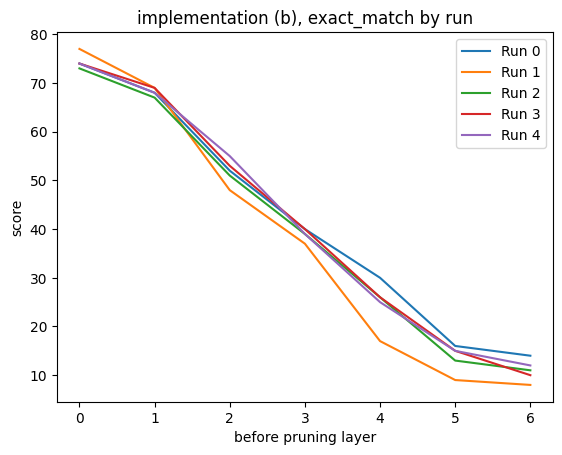

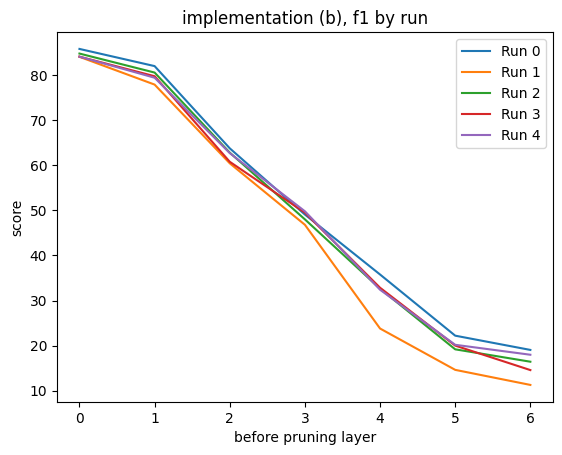

In [ ]:
import matplotlib.pyplot as plt

metrics = list(mets_by_score[0].keys())
for met in metrics:
  for i, exp in enumerate(mets_by_score):
    data = exp[met]
    plt.plot(data, label=f"Run {i}")
  plt.legend()
  plt.ylabel('score')
  plt.xlabel('before pruning layer')
  plt.title(f'implementation (b), {met} by run')
  plt.show()
# for exp in avgs_by_exp:

## data exploration

In [ ]:
from datasets import load_dataset

In [ ]:
train_ds, _, _ = get_data('squad')
train_ds = train_ds[:100]
print(train_ds[:2]['answers'])
print(test[11:20]['answers'])
print(val[:10]['answers'])

  0%|          | 0/2 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
num_examples = len(questions)
for i in range(num_examples):
  answer_start_index = torch.argmax(outputs.start_logits[i])
  answer_end_index = torch.argmax(outputs.end_logits[i])
  predict_answer_tokens = inputs.input_ids[i, answer_start_index : answer_end_index + 1]
  answer = tokenizer.decode(predict_answer_tokens)
  print('TEXT:', texts[i])
  print('QUESTION:', questions[i])
  print('ANSWER:', answer)
  print()

In [ ]:
answers = test_ds[:10]['answers']
for answer in answers:
  print(answer['text'])

['Denver Broncos', 'Denver Broncos', 'Denver Broncos']
['Carolina Panthers', 'Carolina Panthers', 'Carolina Panthers']
['Santa Clara, California', "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."]
['Denver Broncos', 'Denver Broncos', 'Denver Broncos']
['gold', 'gold', 'gold']
['"golden anniversary"', 'gold-themed', '"golden anniversary']
['February 7, 2016', 'February 7', 'February 7, 2016']
['American Football Conference', 'American Football Conference', 'American Football Conference']
['"golden anniversary"', 'gold-themed', 'gold']
['American Football Conference', 'American Football Conference', 'American Football Conference']


In [ ]:
print(val_ds[:10]['id'])

['56e074547aa994140058e4fd', '57302d3ab2c2fd14005689f9', '572f9c0bb2c2fd1400568243', '57281922ff5b5019007d9d3e', '5726ed33f1498d1400e8f006', '57351714879d6814001cab17', '57272dbd708984140094daa9', '56f82a24aef2371900625e76', '5706f6a790286e26004fc777', '572f0842cb0c0d14000f1720']
